# Scanorama experiment

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanorama

In [2]:
# source 3_utils.py
from utils import plot_iroot, comp_kde, kdeplot, kdeplot2

## Load data

In [3]:
d1 = ad.read_h5ad("data/dataseta0_processed.h5ad")
d2 = ad.read_h5ad("data/datasetb0_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [4]:
d1.X = d1.X.todense()
d2.X = d2.X.todense()

adatas_cor = scanorama.correct_scanpy(
    [d1, d2],
    return_dimred = True,
)

adata_scanorama = sc.concat(
    {"control": adatas_cor[0], "premature stop": adatas_cor[1]},
    label="batch",
    uns_merge="unique",
    index_unique="-",
)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


Found 531 genes among all datasets
[[0.         0.98175182]
 [0.         0.        ]]
Processing datasets (0, 1)


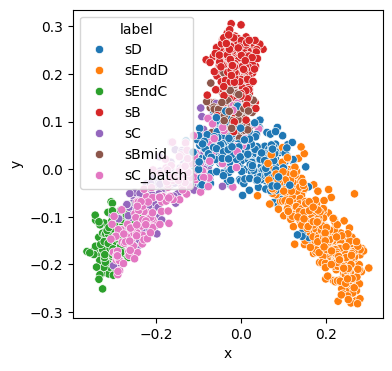

In [5]:
xvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 0] ,adatas_cor[1].obsm["X_scanorama"][:, 0]))
yvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 1] ,adatas_cor[1].obsm["X_scanorama"][:, 1]))
cats = np.concat((adatas_cor[0].obs["milestones"].values ,adatas_cor[1].obs["milestones"].values))

# create a DataFrame for the legend
legend_df = pd.DataFrame({
    "x": xvals,
    "y": yvals,
    "label": cats,
})

with plt.rc_context({"figure.figsize": (4, 4)}):
    sns.scatterplot(
        data=legend_df,
        x="x",
        y="y",
        hue="label",
        legend=True,
    )


/tmp/ipykernel_149183/2965550924.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_scanorama, resolution=1.75, key_added="leiden1.75")


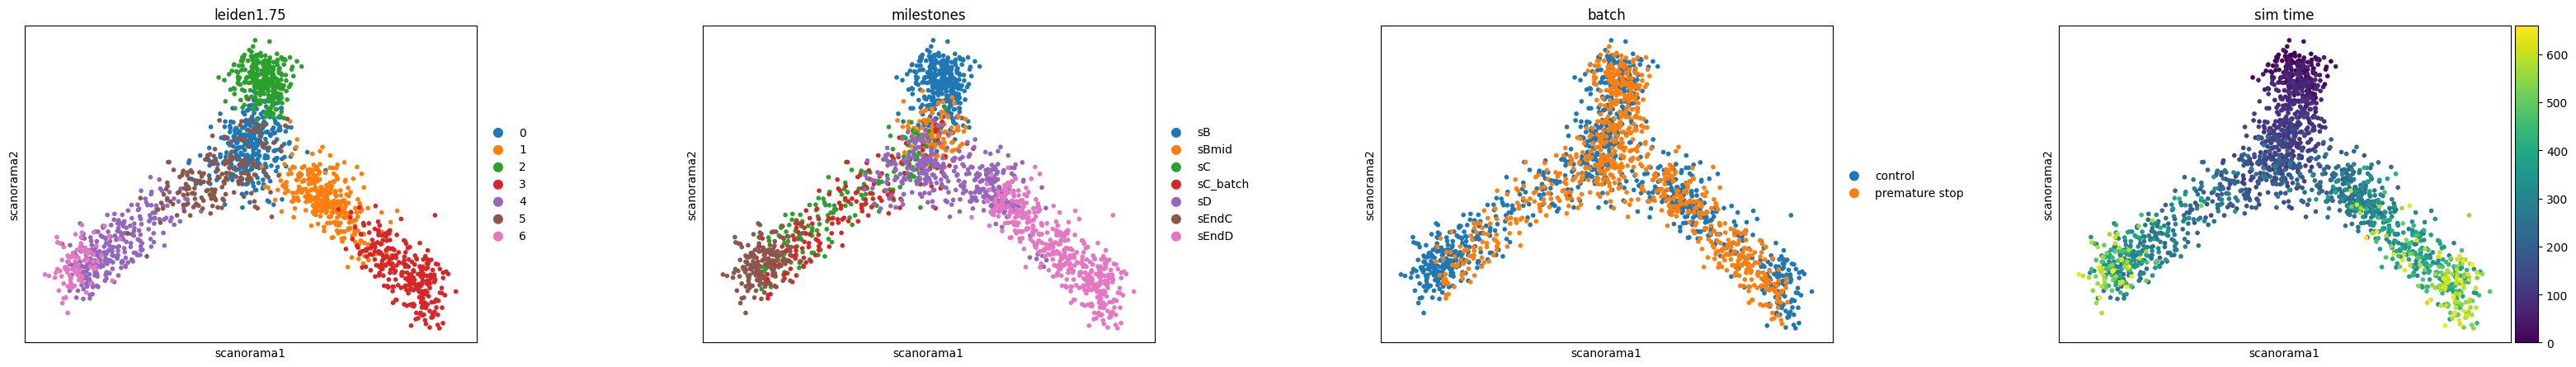

In [6]:
del adata_scanorama.obsm["X_diffmap"]
sc.pp.neighbors(adata_scanorama, use_rep="X_scanorama")
sc.tl.leiden(adata_scanorama, resolution=1.75, key_added="leiden1.75")
sc.pl.scatter(adata_scanorama, basis="scanorama", color=['leiden1.75', 'milestones', 'batch', 'sim_time'])

In [7]:
adata_scanorama.write_h5ad("data/scanorama.h5ad")

In [6]:
adata_scanorama_result = ad.read_h5ad("data/scanorama_slingshot.h5ad")

In [7]:
adata_scanorama_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch', 'leiden1.75', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: 'batch_colors', 'leiden', 'leiden1.75', 'leiden1.75_colors', 'milestones_colors', 'neighbors', 'paga', 'pca', 'traj_milestone_network', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap', 'dimred'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


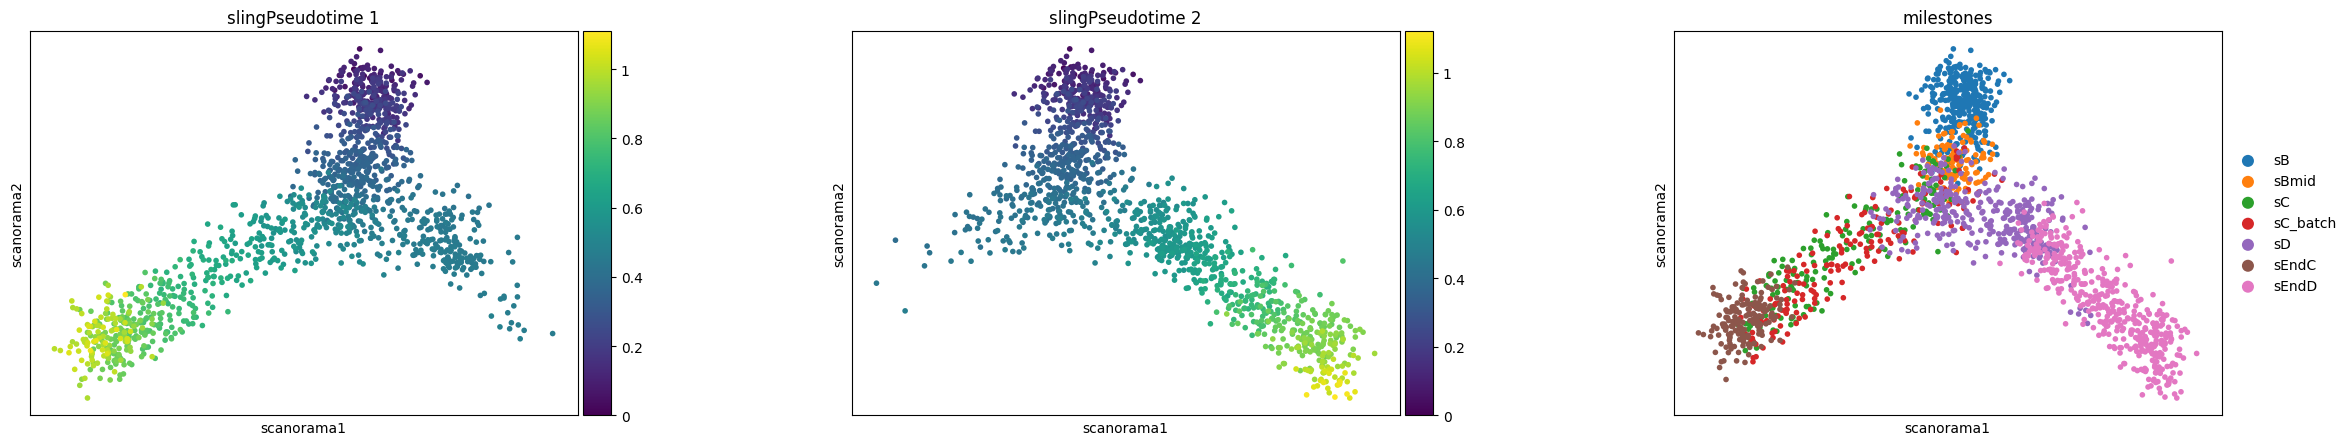

In [8]:
sc.pl.scatter(adata_scanorama_result, basis="scanorama", color=['slingPseudotime_1', 'slingPseudotime_2', "milestones"])

In [18]:
def comp_kde(dataset, milestones, batches = None, milestone_column = "milestones", batch_column = "batch", time_column = "dpt_pseudotime", colors = None, title = None):
    """
    Function to plot the kernel density estimation of the data
    """
    if batches is None:
        batches = dataset.obs[batch_column].cat.categories.values
    if isinstance(milestones, str) or isinstance(milestones, int):
        milestones = [milestones] * len(batches)
    if colors is None:
        colors = [None] * len(batches)

    for batch, milestone, color in zip(batches, milestones, colors):
        dataset_batch = dataset[dataset.obs[batch_column] == batch]
        dataset_batch = dataset_batch[dataset_batch.obs[milestone_column] == milestone]

        # print(dataset_batch.obs.slingPseudotime_1)

        sns.kdeplot(dataset_batch.obs[time_column], label=f"{batch} {milestone}", color=color, fill = True, alpha=0.5)

    plt.legend()
    plt.figure()

In [10]:
# select all cells that are not NA in slingPseudotime_1
clin = adata_scanorama_result[~adata_scanorama_result.obs.slingPseudotime_1.isna()]

In [16]:
%matplotlib inline


In [15]:
fig = sns.kdeplot(clin.obs.dpt_pseudotime, fill = True, alpha=0.5).get_figure()
fig.savefig("scanorama_dpt_pseudotime.png", bbox_inches='tight')

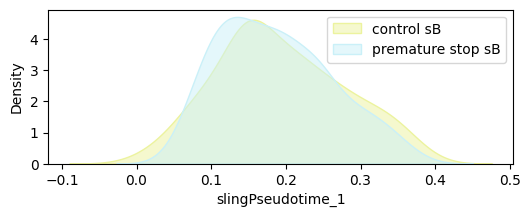

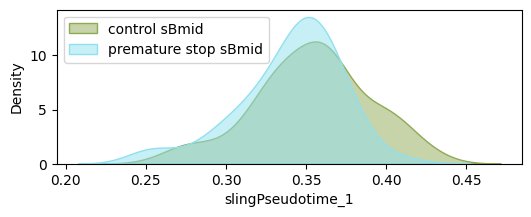

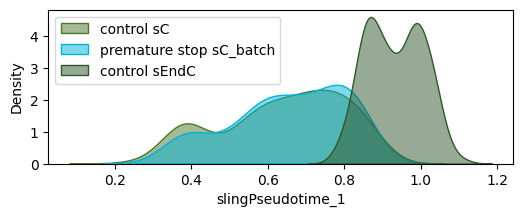

In [19]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", time_column = "slingPseudotime_1", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(clin, "sBmid",time_column = "slingPseudotime_1", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(clin, "control", "sC",time = "slingPseudotime_1", milestone_column = "milestones", color="#4f772d")
    kdeplot2(clin, "premature stop", "sC_batch",time = "slingPseudotime_1", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(clin, "control", "sEndC", time = "slingPseudotime_1",milestone_column = "milestones", color="#31572c")
    plt.legend()

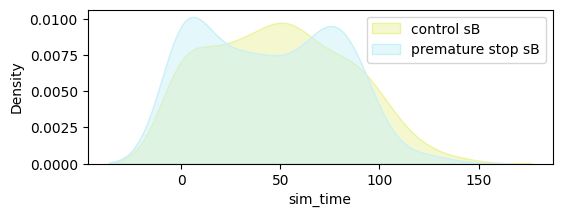

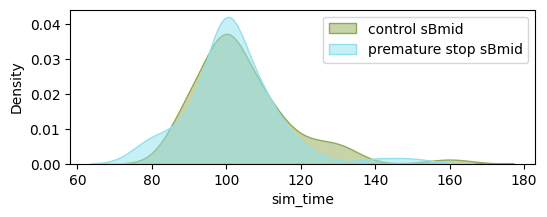

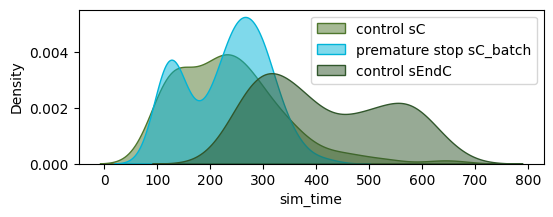

In [20]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", colors = ["#ecf39e", "#caf0f8"], time_column="sim_time")
    comp_kde(clin, "sBmid", colors = ["#90a955", "#90e0ef"], time_column="sim_time")
    
    kdeplot2(clin, "control", "sC", milestone_column = "milestones", color="#4f772d", time="sim_time")
    kdeplot2(clin, "premature stop", "sC_batch", milestone_column = "milestones", color="#00b4d8", time="sim_time")
    kdeplot2(clin, "control", "sEndC", milestone_column = "milestones", color="#31572c",  time="sim_time")
    plt.legend()